# Designing adaptive experiments to study working memory

Suppose you are shown a sequence of digits

$$ 1\ 4\ 7\ 0\ 9 $$

which are then hidden. You have to to reproduce the sequence exactly from memory. In the next round, the length of the sequence may be different

$$ 6\ 5\ 0\ 2\ 8\ 0 .$$

The longest sequence that you can remember is your working memory capacity. In this tutorial, we build a Bayesian model for working memory, and use it to run an adaptive sequence of experiments that very quickly learn someone's working memory capacity.


## A model of working memory
Our model for a single round of the digits experiment described above has three components: the length $l$ of the sequence that the participant has to remember, the participant's true working memory capacity $\theta$, and the outcome of the experiment $y$ which indicates whether they were able to remember the sequence successfully ($y=1$) or not ($y=0$).

**Note**: $\theta$ actually represents the point where the participants has a 50/50 chance of remembering the sequence correctly.

In [1]:
import torch

import pyro
import pyro.distributions as dist


sensitivity = 1.0
prior_mean = torch.tensor(7.0)
prior_sd = torch.tensor(2.5)


def model(l):
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    logit_p = sensitivity * (theta - l)
    y = pyro.sample("y", dist.Bernoulli(logits=logit_p))
    return y

The probability of successfully remembering the sequence is plotted below, for five random samples of $\theta$.

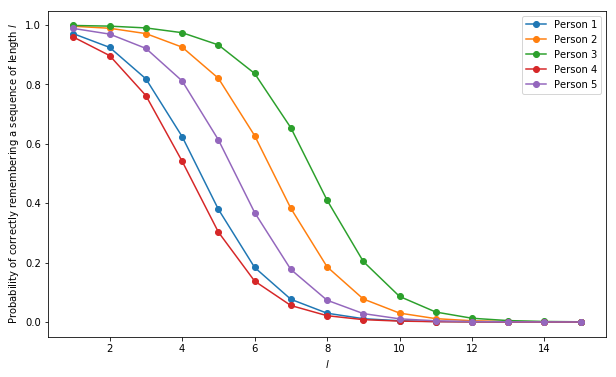

In [20]:
import torch
import matplotlib.pyplot as plt

theta = (prior_mean + prior_sd * torch.randn((5,1)))
plt.figure(figsize=(10, 6))
l = torch.arange(1, 16, dtype=torch.float)
prob = torch.sigmoid(sensitivity * (theta - l))
for curve in torch.unbind(prob, 0):
    plt.plot(l.numpy(), curve.numpy(), marker='o')
plt.xlabel("$l$")
plt.ylabel("Probability of correctly remembering a sequence of length $l$")
plt.legend(["Person {}".format(i+1) for i in range(5)])
plt.show()

## Inference in the model

With the model in hand, we quickly demonstrate variational inference in Pyro for this model. We will set up the inference to handle any number of rounds.

In [3]:
from contextlib import ExitStack
from pyro.contrib.util import iter_plates_to_shape, rexpand

def multiround_model(l):
    # The shape of l is (batch dims..., number of rounds)
    with ExitStack() as stack:
        for plate in iter_plates_to_shape(l.shape[:-1]):
            stack.enter_context(plate)
        theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
        theta = rexpand(theta, l.shape[-1])
        logit_p = sensitivity * (theta - l)
        y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
        return y

We also define a Normal guide for variational inference.

In [4]:
from torch.distributions.constraints import positive

def guide(l):
    posterior_mean = pyro.param("posterior_mean", prior_mean.clone())
    posterior_sd = pyro.param("posterior_sd", prior_sd.clone(), constraint=positive)
    pyro.sample("theta", dist.Normal(posterior_mean, posterior_sd))

We finally specify the following data: the participant was shown sequences of lengths 5, 7 and 9. They remembered the first two correctly, but not the third one.

In [5]:
l_data = torch.tensor([5., 7., 9.])
y_data = torch.tensor([1., 1., 0.])

We can now run SVI on the model.

In [22]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

conditioned_model = pyro.condition(multiround_model, {"y": y_data})
svi = SVI(conditioned_model,
          guide,
          Adam({"lr": .001}),
          loss=Trace_ELBO(),
          num_samples=100)
pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(l_data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 1.7387651205062866
Elbo loss: 1.5262939929962158
Elbo loss: 2.2794265747070312
Elbo loss: 1.1524869203567505
Elbo loss: 1.198934555053711
Elbo loss: 1.2467598915100098
Elbo loss: 1.3257390260696411
Elbo loss: 1.3553131818771362
Elbo loss: 1.4036697149276733
Elbo loss: 1.413097083568573


In [23]:
print("Posterior mean:", pyro.param("posterior_mean").item())
print("Posterior std dev:", pyro.param("posterior_sd").item())

Posterior mean: 7.889351844787598
Posterior std dev: 1.2678310871124268


## Bayesian optimal experimental design
So far so standard. In the previous example, the lengths `l_data` were not chosen with a great deal of forethought. Fortunately, in a setting like this, it is possible to use a more sophisticated strategy to choose the sequence lengths to make the most of every question we ask.

We do this using Bayesian optimal experimental design (BOED). In BOED, we are interested in designing experiments that maximise the information gain, which is defined formally as

$$ \text{IG}(l, y) = KL(p(\theta|y,l)||p(\theta)) .$$

In words, the information gain is the KL divergence from the posterior to the prior. It therefore represents the distance we "move" the posterior by running an experiment with length $l$ and getting back the outcome $y$.

Unfortunately, we will not know $y$ until we actually run the experiment. Therefore, we choose $l$ on the basis of the *expected* information gain

$$\text{EIG}(l) = \mathbb{E}_{y\sim p(y|\theta,l)}\quad [KL(p(\theta|y,l)||p(\theta))]. $$

Because it features the posterior density $p(y|\theta,l)$, the EIG is not immediately tractable. However, we can make use of the following formula for EIG

$$\text{EIG}(l) = \min_q \mathbb{E}_{\theta,y \sim p(\theta)p(y|\theta,l)}\quad \left[ \log \frac{p(y|\theta,l)}{q(y)} \right].$$

### Optimal experimental design in Pyro
Fortunately, Pyro comes ready with tools to estimate the EIG. All we have to do is define the "marginal guide" $q(y)$ in the formula above.

In [24]:
def marginal_guide(design, observation_labels, target_labels):
    p_logit = pyro.param("p_logit", torch.zeros(design.shape[-2:]))
    pyro.sample("y", dist.Bernoulli(logits=p_logit).to_event(1))

In [25]:
from pyro.contrib.oed.eig import marginal_eig

# The shape is (number designs, 1)
candidate_designs = torch.arange(1, 15, dtype=torch.float).unsqueeze(-1)
pyro.clear_param_store()

# Pre-train
marginal_eig(multiround_model, candidate_designs, "y", "theta", num_samples=100,
             num_steps=500, guide=marginal_guide, optim=Adam({"lr": 0.1}))
# Compute EIG
eig = marginal_eig(multiround_model, candidate_designs, "y", "theta", num_samples=100,
                   num_steps=1000, guide=marginal_guide, optim=Adam({"lr": 0.002}),
                   final_num_samples=10000)

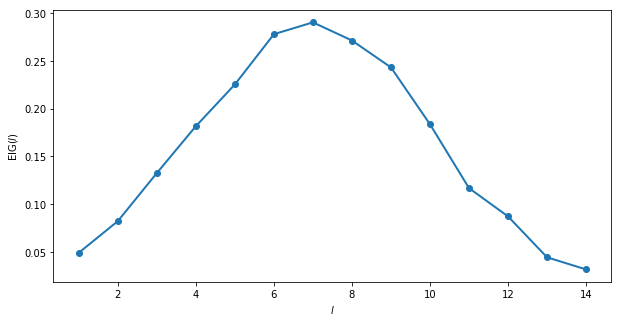

In [26]:
plt.figure(figsize=(10,5))
plt.plot(candidate_designs.numpy(), eig.detach().numpy(), marker='o', linewidth=2)
plt.xlabel("$l$")
plt.ylabel("EIG($l$)")
plt.show()

In [27]:
best_l = 1 + torch.argmax(eig)
print("Optimal design:", best_l.item())

Optimal design: 7


This tells us that the first round should be run with a sequence of length 7. This framework applies equally well to more sophisticated models and experiments.

## The adaptive experiment

We now have the ingredients to build an adaptive experiment to study working memory. We repeat the following steps:
1. Use the EIG to find the optimal sequence length $l$
2. Run the test using a sequence of length $l$
3. Update the posterior distribution with the new data


At the first iteration, step 1 is done using the prior as above. However, for subsequent iterations, we use the posterior given all the data so far.

In this notebook, the "experiment" is performed using the following synthesiser

In [12]:
def synthetic_person(l):
    y = (l < 6.).float()
    return y

The following code allows us to update the model as we gather more data.

In [13]:
def make_model(mean, sd):
    def model(l):
        # The shape of l is (batch dims..., number of rounds)
        with ExitStack() as stack:
            for plate in iter_plates_to_shape(l.shape[:-1]):
                stack.enter_context(plate)
            theta = pyro.sample("theta", dist.Normal(mean, sd))
            theta = rexpand(theta, l.shape[-1])
            logit_p = sensitivity * (theta - l)
            y = pyro.sample("y", dist.Bernoulli(logits=logit_p).to_event(1))
            return y
    return model

Now we have everything to run a 10-step experiment using adaptive designs.

In [38]:
ys = torch.tensor([])
ls = torch.tensor([])
history = [(prior_mean, prior_sd)]
pyro.clear_param_store()
model = make_model(prior_mean, prior_sd)

for experiment in range(10):
     
    # Step 1: compute the optimal length
    # Pre-train
    marginal_eig(model, candidate_designs, "y", "theta", num_samples=100,
                 num_steps=500, guide=marginal_guide, optim=Adam({"lr": 0.1}))
    # Compute EIG
    eig = marginal_eig(model, candidate_designs, "y", "theta", num_samples=100,
                       num_steps=500, guide=marginal_guide, optim=Adam({"lr": 0.002}),
                       final_num_samples=10000)
    best_l = 1 + torch.argmax(eig).float().detach()
    print("Best sequence length", best_l.item())
    
    # Step 2: run the experiment, here using the synthetic person
    y = synthetic_person(best_l)
    print("Experiment outcome", y.item())
    ls = torch.cat([ls, best_l.expand(1)], dim=0)
    ys = torch.cat([ys, y.expand(1)])
    
    # Step 3
    conditioned_model = pyro.condition(multiround_model, {"y": ys})
    svi = SVI(conditioned_model,
              guide,
              Adam({"lr": .005}),
              loss=Trace_ELBO(),
              num_samples=100)
    num_iters = 2000
    for i in range(num_iters):
        elbo = svi.step(ls)
        
    history.append((pyro.param("posterior_mean").detach().clone().numpy(),
                    pyro.param("posterior_sd").detach().clone().numpy()))
    model = make_model(pyro.param("posterior_mean").detach().clone(),
                       pyro.param("posterior_sd").detach().clone())

Best sequence length 7.0
Experiment outcome 0.0
Best sequence length 5.0
Experiment outcome 1.0
Best sequence length 7.0
Experiment outcome 0.0
Best sequence length 5.0
Experiment outcome 1.0
Best sequence length 6.0
Experiment outcome 0.0
Best sequence length 5.0
Experiment outcome 1.0
Best sequence length 6.0
Experiment outcome 0.0
Best sequence length 5.0
Experiment outcome 1.0
Best sequence length 6.0
Experiment outcome 0.0
Best sequence length 6.0
Experiment outcome 0.0


Now let's visualize the evolution of the posterior:

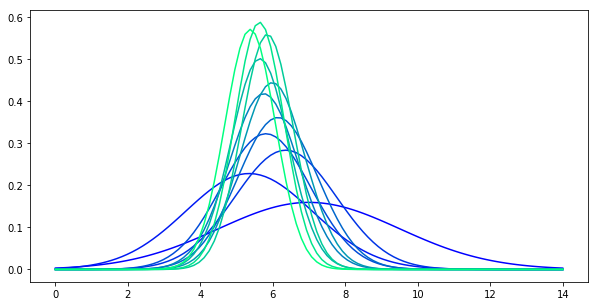

In [39]:
import numpy as np
from scipy.stats import norm
import matplotlib.colors as colors
import matplotlib.cm as cmx


cmap = plt.get_cmap('winter') 
cNorm  = colors.Normalize(vmin=0, vmax=len(history)-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

plt.figure(figsize=(10, 5))
x = np.linspace(0, 14, 100)
for idx, (mean, sd) in enumerate(history):
    color = scalarMap.to_rgba(idx)
    y = norm.pdf(x, mean, sd)
    plt.plot(x, y, color=color)

By contrast, suppose we use a simplistic design: try sequences of lengths 1, 2, ..., 10.

In [40]:
pyro.clear_param_store()
ls = torch.arange(1, 11, dtype=torch.float)
ys = synthetic_person(ls)
conditioned_model = pyro.condition(multiround_model, {"y": ys})
svi = SVI(conditioned_model,
          guide,
          Adam({"lr": .005}),
          loss=Trace_ELBO(),
          num_samples=100)
num_iters = 2000
for i in range(num_iters):
    elbo = svi.step(ls)

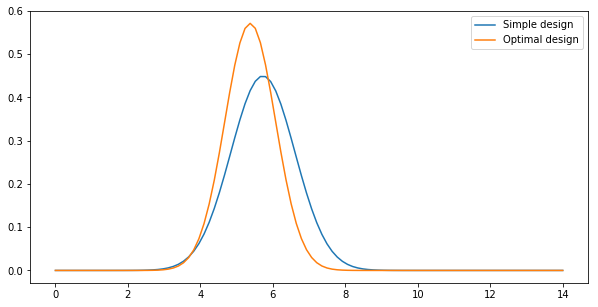

In [41]:
plt.figure(figsize=(10,5))
y1 = norm.pdf(x, pyro.param("posterior_mean").detach().numpy(),
              pyro.param("posterior_sd").detach().numpy())
y2 = norm.pdf(x, history[-1][0], history[-1][1])
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(["Simple design", "Optimal design"])
plt.show()

Although both design strategies give us data, the optimal strategy ends up with a posterior distribution that is more peaked: that means we have greater confidence in our final answer, or may be able to stop experimenting earlier.

## Extensions

The model in this tutorial is very simple and could be extended in a number of ways. For instance, it's possible that as well as measuring whether the participant did or did not remember the sequence, we might collect some other information as well. We could build a model for the number of mistakes made (e.g. the edit distance between the correct sequence and the participant's response) or jointly model the correctness and the time taken to respond. Here is an example model where we model the response time using a LogNormal distribution.

In [42]:
time_intercept = 0.5
time_scale = 0.5

def model(l):
    theta = pyro.sample("theta", dist.Normal(prior_mean, prior_sd))
    logit_p = sensitivity * (theta - l)
    correct = pyro.sample("correct", dist.Bernoulli(logits=logit_p))
    mean_log_time = time_intercept + time_scale * (theta - l)
    time = pyro.sample("time", dist.LogNormal(mean_log_time, 1.0))
    return correct, time

It would still be possible to compute the EIG using `marginal_eig`. We would replace `"y"` by `["correct", "time"]` and the marginal guide would now model a joint distribution over the two sites `"correct"` and `"time"`.

Our model also made a number of assumptions that we may choose to relax. For instance, we assumed that all sequences of the same length are equally easy to remember. We also fixed the `sensitivity` to be a known constant: it's likely we would need to learn this. We could also think about learning at two levels: learning global variables for population trends as well as local variables for individual level effects. The current model is an individual only model. The EIG could still be used as a means to select the optimal design in such scenarios.